### Genetic Algorithm Can Accurately Navigate Structure Space for Low Viscosity Ionic Liquids
1. X versions - no RDKit integration
2. X versions - RDKit integration
    1. atomic mutations, alpha-num fitness test, fixed bonds, non-random starting structure
    2. atomic mutations, similarity map fitness test, fixed bonds, non-random starting structure
    3. atomic mutations, similarity map fitness test, bond mutations, non-random starting structure
    4. atomic mutations, similarity map fitness test, bond mutations, random starting structure
3. X versions - viscosity fitness tests
4. X versions - performance upgrades using clustering/similarity maps
5. X versions - different search structures


In [1]:
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdFMCS
import random
import os
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

# Replace atoms

In [2]:
class Chromosome(Chem.rdchem.Mol):
    def __init__(self, genes, fitness):
        Chem.rdchem.Mol.__init__(self)
        self.Genes = genes
        self.Fitness = fitness
        self.Mol = Chem.MolFromSmiles(genes)
def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0],fps[1])
def mutate(parent, geneSet, get_fitness):
    childGenes = parent
    while True:
        oldGene, alternate = random.sample(range(0,childGenes.Mol.GetNumAtoms()), 2)
        if childGenes.Mol.GetAtomWithIdx(alternate).IsInRing() == False and\
                childGenes.Mol.GetAtomWithIdx(oldGene).IsInRing() == False:
            break
    newGene = random.sample(geneSet, 1)[0]
    try:
        childGenes.Mol.GetAtomWithIdx(alternate).SetAtomicNum(newGene) if\
              childGenes.Mol.GetAtomWithIdx(oldGene).GetFormalCharge() != 0 else\
              childGenes.Mol.GetAtomWithIdx(oldGene).SetAtomicNum(newGene)
        Chem.SanitizeMol(childGenes.Mol)
        genes = Chem.MolToSmiles(childGenes.Mol)
        fitness = get_fitness(genes, target)
        return Chromosome(genes, fitness)
    except:
        genes = Chem.MolToSmiles(parent.Mol)
        return Chromosome(genes, 0)
        pass    

In [6]:
target = "CNCN[NH+]1C=CN(C1C)C"
geneSet = [5,6,7,8,9,15,16] #B,C,N,O,F,P,S
genes = "CCCC[NH+]1C=CN(C1C)C"
fitness = get_fitness(genes, target)
parent = Chromosome(genes,fitness)
print(parent.Fitness)
while parent.Fitness < 0.6:
    child = mutate(parent, geneSet, get_fitness)
    if child.Fitness > parent.Fitness:
        print("{}\t{}\t{}".format("child adopted!",child.Genes,child.Fitness))
        parent = child

0.36524822695035464
child adopted!	BN1C=C[NH+](CCCF)C1C	0.3730407523510972
child adopted!	FPCC[NH+]1C=CN(P)C1S	0.375366568914956
child adopted!	BNNN[NH+]1C=CN(C)C1P	0.40390879478827363
child adopted!	BNNN[NH+]1C=CN(C)C1N	0.41496598639455784
child adopted!	BC1N(O)C=C[NH+]1NCON	0.41590214067278286
child adopted!	CCCC[NH+]1C=CN(N)C1P	0.4336569579288026
child adopted!	NN1C=C[NH+](CCCF)C1P	0.43450479233226835
child adopted!	NN1C=C[NH+](CCCP)C1P	0.43870967741935485
child adopted!	CC1N(N)C=C[NH+]1NNOF	0.4391891891891892
child adopted!	CONN[NH+]1C=CN(P)C1C	0.4668769716088328
child adopted!	CC1N(C)C=C[NH+]1NONP	0.5519713261648745
child adopted!	CC1N(C)C=C[NH+]1NONN	0.5543478260869565
child adopted!	CC1N(C)C=C[NH+]1NOCN	0.573943661971831
child adopted!	CC1N(C)C=C[NH+]1NBBN	0.6174242424242424
child adopted!	CC1N(N)C=C[NH+]1NCNN	0.6245059288537549
child adopted!	CC1N(C)C=C[NH+]1NCSP	0.7222222222222222


# Add atoms

GA is biased toward removing atoms with current similarity mapping. A good solution with be one that improves the overall functionality of the genetic engine.

try: 
1. bias until number of atoms match target
2. find MCS and start from there
3. combination of 1 and 2
4. **add segments to geneSet**


In [4]:
class Chromosome(Chem.rdchem.Mol):
    def __init__(self, genes, fitness):
        Chem.rdchem.Mol.__init__(self)
        self.Genes = genes
        self.Fitness = fitness
        self.Mol = Chem.MolFromSmiles(genes)
        self.RWMol = Chem.RWMol(Chem.MolFromSmiles(genes))
def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0],fps[1])
def mutate(parent, geneSet, get_fitness):
    childGenes = parent
    mutate_operations = ["replace atom", "add atom", "remove atom"]
    mutation_type = random.sample(mutate_operations, 1)[0]
    if mutation_type == "replace atom":
        while True:
            oldGene, alternate = random.sample(range(0,childGenes.RWMol.GetNumAtoms()), 2)
            if childGenes.RWMol.GetAtomWithIdx(alternate).IsInRing() == False and\
                    childGenes.RWMol.GetAtomWithIdx(oldGene).IsInRing() == False:
                break
        newGene = random.sample(geneSet, 1)[0]
        try:
            childGenes.RWMol.GetAtomWithIdx(alternate).SetAtomicNum(newGene) if\
                  childGenes.RWMol.GetAtomWithIdx(oldGene).GetFormalCharge() != 0 else\
                  childGenes.RWMol.GetAtomWithIdx(oldGene).SetAtomicNum(newGene)
            Chem.SanitizeMol(childGenes.RWMol)
            genes = Chem.MolToSmiles(childGenes.RWMol)
            fitness = get_fitness(genes, target)
            return Chromosome(genes, fitness)
        except:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
            pass    
    elif mutation_type == "remove atom":
        
        while True:
            oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]
            if childGenes.RWMol.GetAtomWithIdx(oldGene).GetExplicitValence() == 1:
                break
        try:
            childGenes.RWMol.RemoveAtom(oldGene)
            childGenes.RWMol.UpdatePropertyCache(strict=True)
            Chem.SanitizeMol(childGenes.RWMol)
            genes = Chem.MolToSmiles(childGenes.RWMol)
            fitness = get_fitness(genes, target)
            return Chromosome(genes, fitness)
        except:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
            pass

    elif mutation_type == "add atom":
        oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]
        newGeneNumber = childGenes.RWMol.GetNumAtoms()
        
        try:
            childGenes.RWMol.AddAtom(Chem.Atom(newGene))
            childGenes.RWMol.AddBond(newGeneNumber,oldGene,Chem.BondType.SINGLE) 
            childGenes.RWMol.UpdatePropertyCache(strict=True)
            Chem.SanitizeMol(childGenes.RWMol)
            genes = Chem.MolToSmiles(childGenes.RWMol)
            fitness = get_fitness(genes, target)
            return Chromosome(genes, fitness)
        except:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
            pass

In [ ]:
target = "CNCN[NH+]1C=CN(C1C)C"
geneSet = [5,6,7,8,9,15,16] #B,C,N,O,F,P,S
genes = "CCCC[NH+]1C=CN(C1C)C"
fitness = get_fitness(genes, target)
parent = Chromosome(genes,fitness)
print("{}\t{}\t{}".format("a new parent!",parent.Genes,parent.Fitness))
while parent.Fitness < 0.5:
    child = mutate(parent, geneSet, get_fitness)
    if child.Fitness > parent.Fitness:
        print("{}\t{}\t{}".format("child adopted!",child.Genes,child.Fitness))
        parent = child
        mw = Chem.MolFromSmiles(parent.Genes)
        ax = Draw.MolToMPL(mw)

a new parent!	CCCC[NH+]1C=CN(C1C)C	0.36524822695035464
child adopted!	CCCO[NH+]1C=CN(C)C1C	0.3924050632911392
child adopted!	CCO[NH+]1C=CN(C)C1C	0.39603960396039606
child adopted!	BN1C=C[NH+](OC)C1	0.417910447761194

# Add fragments

In [13]:
geneSet = [5,6,7,8,9,15,16] #B,C,N,O,F,P,S
funGroupGenes = "CCCC"
baseGenes = "[NH+]1C=CN(C1C)C"
funGroup = Chromosome(funGroupGenes,1)
base = Chromosome(baseGenes,1)
combined = Chem.CombineMols(base.Mol,funGroup.Mol)
combined = Chem.EditableMol(combined)
combined.AddBond(7,8,Chem.BondType.SINGLE)
ax = Draw.MolToMPL(combined)

RuntimeError: Pre-condition Violation
	bond already exists
	Violation occurred on line 268 in file Code/GraphMol/RWMol.cpp
	Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
	RDKIT: 2017.03.3
	BOOST: 1_56


will bond new atom to 3
bonded atom did not sanitize
atom N ring status and valence:	True	3
atom C ring status and valence:	True	3
atom C ring status and valence:	True	3
atom N ring status and valence:	True	3
atom C ring status and valence:	True	3
atom C ring status and valence:	False	1
atom C ring status and valence:	False	1


0.5245901639344263

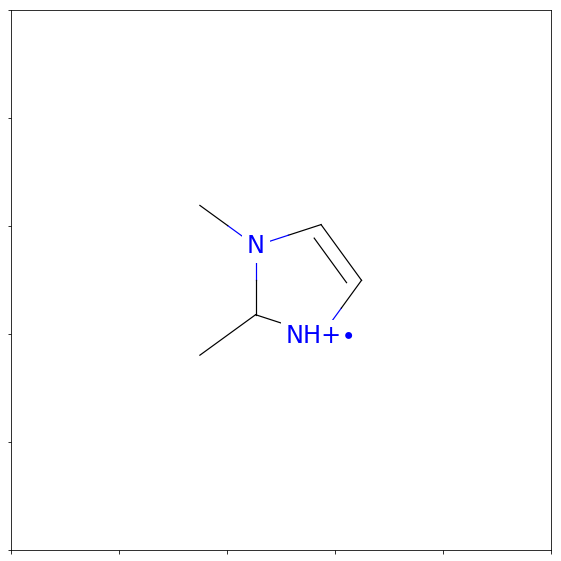

In [200]:
target = "CCCC[NH+]1C=CN(C1C)C"
genes = "[NH+]1C=CN(C1C)C"
geneSet = [6]#C

m = Chem.MolFromSmiles(genes)
mw = Chem.RWMol(m)
mutate_operations = ["replace atom", "add atom", "remove atom"]
mutation_type = random.sample(mutate_operations, 1)[0]
newGene = random.sample(geneSet, 1)[0]


if mutation_type == "replace atom":
    print("will replace atom")
    
elif mutation_type == "remove atom":
    print("will remove atom")
    while True:
        oldGene = random.sample(range(mw.GetNumAtoms()), 1)[0]
        if mw.GetAtomWithIdx(oldGene).GetExplicitValence() == 1:
            break
    try:
        mw.RemoveAtom(oldGene)
        mw.UpdatePropertyCache(strict=True)
        Chem.SanitizeMol(mw)
    except:
        print("removed atom did not sanitize")
        pass
    
elif mutation_type == "add atom":
    oldGene = random.sample(range(mw.GetNumAtoms()), 1)[0]
    newGeneNumber = mw.GetNumAtoms()
    print("will bond new atom to %s" % oldGene)
    try:
        mw.AddAtom(Chem.Atom(newGene))
        mw.AddBond(newGeneNumber,oldGene,Chem.BondType.SINGLE) 
        mw.UpdatePropertyCache(strict=True)
        Chem.SanitizeMol(mw)
    except:
        print("bonded atom did not sanitize")
        mw.RemoveAtom(newGeneNumber)
        pass
        
for atom in mw.GetAtoms():
    print("{}\t{}\t{}".format("atom %s ring status and valence:"\
            %atom.GetSymbol(), atom.IsInRing(), atom.GetExplicitValence()))
    
Chem.MolToSmiles(mw)
ax=Draw.MolToMPL(mw)

target_chrome = Chromosome(target,fitness)
target = Chem.MolToSmiles(target_chrome.Mol)
genes = Chem.MolToSmiles(mw)
parent = Chromosome(genes,fitness)
genes = Chem.MolToSmiles(parent.Mol)
fitness = get_fitness(genes, target)
parent.Fitness

In [178]:
from rdkit.Chem import FragmentCatalog
from rdkit import RDConfig
fName=os.path.join(RDConfig.RDDataDir,'FunctionalGroups.txt')
fparams = FragmentCatalog.FragCatParams(1,6,fName)
fparams.GetNumFuncGroups()

39

In [18]:
fcat=FragmentCatalog.FragCatalog(fparams)
fcgen=FragmentCatalog.FragCatGenerator()
m = Chem.MolFromSmiles('OCC=CC(=O)O')
fcgen.AddFragsFromMol(m,fcat)

3

number of atoms: 	11
atom N ring status and valence:	False	1
atom C ring status and valence:	False	2
atom N ring status and valence:	False	2
atom C ring status and valence:	False	2
atom N ring status and valence:	True	4
atom C ring status and valence:	True	3
atom C ring status and valence:	True	3
atom N ring status and valence:	True	3
atom C ring status and valence:	True	3
atom C ring status and valence:	False	1
atom C ring status and valence:	False	1


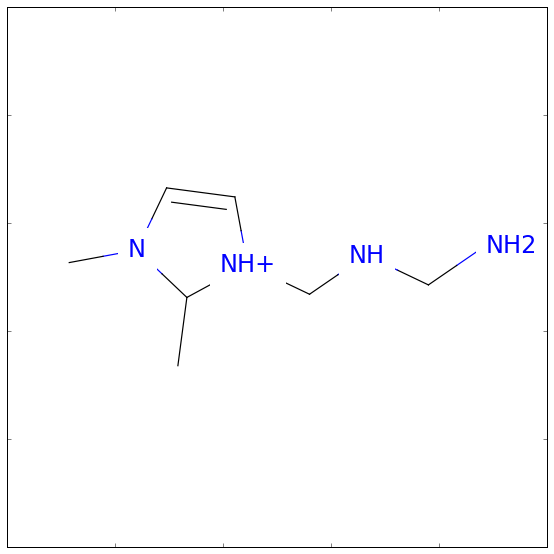

In [3]:
start = "NCNC[NH+]1C=CN(C1C)C"
target = "CCCC[NH+]1C=CN(C1C)C"
mol = Chem.MolFromSmiles(target)
print("{}\t{}".format("number of atoms: ", mol.GetNumAtoms()))
for atom in mol.GetAtoms():
    print("{}\t{}\t{}".format("atom %s ring status and valence:"\
            %atom.GetSymbol(), atom.IsInRing(), atom.GetExplicitValence()))
ax1=Draw.MolToMPL(mol)

number of atoms: 	8
atom C ring status:	False
atom C ring status:	False
atom N ring status:	False
atom C ring status:	False
atom C ring status:	False
atom N ring status:	False
atom C ring status:	False
atom C ring status:	False


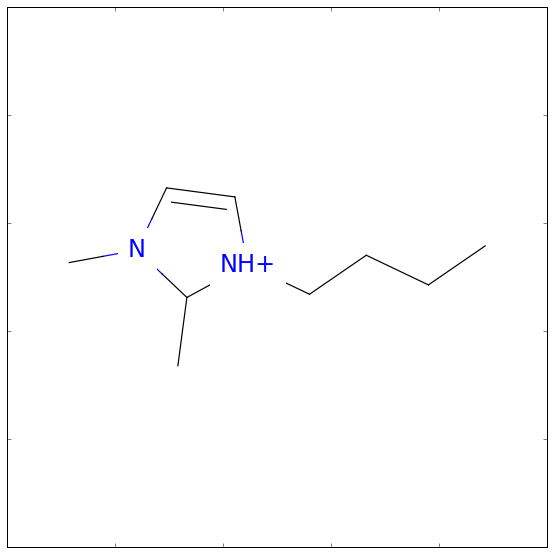

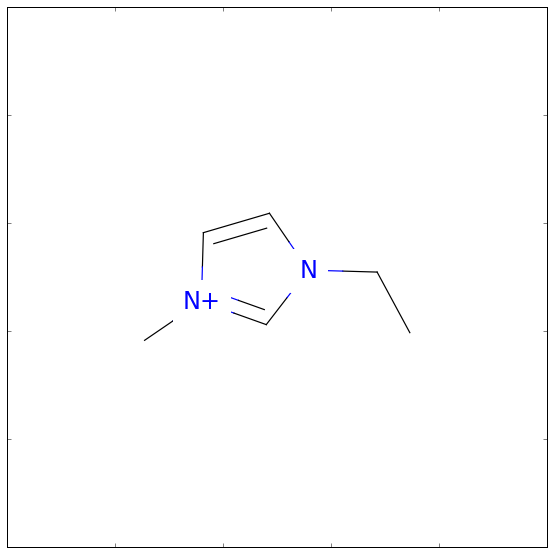

In [58]:
df = pd.read_csv("saltInfo.csv")
mol1 = Chem.MolFromSmiles(df["cation_SMILES"][0])
mol2 = Chem.MolFromSmiles(df["cation_SMILES"][1])
mols = [mol1,mol2]
res=rdFMCS.FindMCS(mols)
mol = Chem.MolFromSmarts(res.smartsString)
print("{}\t{}".format("number of atoms: ", mol.GetNumAtoms()))
for atom in mol.GetAtoms():
    print("{}\t{}".format("atom %s ring status:"\
            %atom.GetSymbol(), atom.IsInRing()))
ax1=Draw.MolToMPL(mol1)
ax2=Draw.MolToMPL(mol2)